## Importing the relevant libraries

In [166]:
import torch, time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [167]:
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device())
    print("Device Name:", torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


## Loading the dataset

In [168]:
df = pd.read_csv("/kaggle/input/drug-classification/drug200.csv")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## Data Exploration

In [169]:
df.shape

(200, 6)

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [171]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [172]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [173]:
df.duplicated().sum()

0

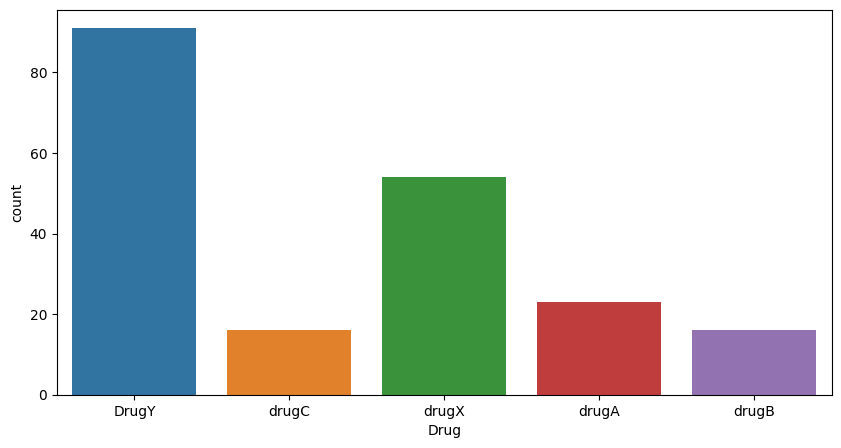

In [174]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df,x='Drug')
plt.show();

## Encoding the target label classes

In [175]:
encoder = LabelEncoder()
df.Drug = encoder.fit_transform(df[['Drug']])
df.Drug = df.Drug.astype(float)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [176]:
encoded_labels = {}

for idx, label in enumerate(encoder.classes_):
    encoded_labels[idx] = label

encoded_labels

{0: 'DrugY', 1: 'drugA', 2: 'drugB', 3: 'drugC', 4: 'drugX'}

In [177]:
cat_cols = list(df.select_dtypes(object).columns)
cont_cols = list(df.drop('Drug',axis=1).select_dtypes(np.number).columns)
y_col = 'Drug'

# Converting datatype of categorical columns to 'category'
for col in cat_cols:
    df[col] = df[col].astype('category')

## Converting categorical and numerical features into Torch tensors

In [178]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols],axis=1)
cats[:5]

array([[0, 0, 0],
       [1, 1, 0],
       [1, 1, 0],
       [0, 2, 0],
       [0, 1, 0]], dtype=int8)

In [179]:
cats = torch.tensor(cats,dtype=torch.int64)
cats[:5]

tensor([[0, 0, 0],
        [1, 1, 0],
        [1, 1, 0],
        [0, 2, 0],
        [0, 1, 0]])

In [180]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)
conts[:5]

array([[23.   , 25.355],
       [47.   , 13.093],
       [47.   , 10.114],
       [28.   ,  7.798],
       [61.   , 18.043]])

In [181]:
conts = torch.tensor(conts,dtype=torch.float32)
conts[:5]

tensor([[23.0000, 25.3550],
        [47.0000, 13.0930],
        [47.0000, 10.1140],
        [28.0000,  7.7980],
        [61.0000, 18.0430]])

In [182]:
y = torch.tensor(df[y_col].values,dtype=torch.long).flatten()
y[:20]

tensor([0, 3, 3, 4, 0, 4, 0, 3, 0, 0, 3, 0, 0, 0, 4, 0, 4, 1, 3, 0])

In [183]:
cats.shape, conts.shape, y.shape

(torch.Size([200, 3]), torch.Size([200, 2]), torch.Size([200]))

## Splitting the categorical and continuous features into train and test sets

In [184]:
test_size = int(0.2 * df.shape[0])

cat_train = cats[:-test_size]
cat_test = cats[-test_size:]
cont_train = conts[:-test_size]
cont_test = conts[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [185]:
cat_train.shape, cat_test.shape

(torch.Size([160, 3]), torch.Size([40, 3]))

In [186]:
cont_train.shape, cont_test.shape

(torch.Size([160, 2]), torch.Size([40, 2]))

In [187]:
y_train.shape, y_test.shape

(torch.Size([160]), torch.Size([40]))

In [188]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
embedding_szs = [(size,min(50,(1+size)//2)) for size in cat_szs]
embedding_szs

[(2, 1), (3, 2), (2, 1)]

## Designing the model architecture

In [189]:
class ANN(nn.Module):
    
    def __init__(self,embedding_sizes,num_cont_features,output_size,layers,p=0.5):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(ni,nf) for ni, nf in embedding_sizes])
        self.embeddings_dropout = nn.Dropout(p)
        self.cont_batch_norm = nn.BatchNorm1d(num_cont_features)
        total_embeddings = sum([nf for ni, nf in embedding_sizes])
        n_inputs = total_embeddings + num_cont_features
        layerList = []
        
        for num_layers in layers:
            layerList.append(nn.Linear(n_inputs,num_layers))
            layerList.append(nn.ReLU(inplace=True))
            layerList.append(nn.BatchNorm1d(num_layers))
            layerList.append(nn.Dropout(p))
            n_inputs = num_layers
        
        layerList.append(nn.Linear(layers[-1],output_size))
        self.layers = nn.Sequential(*layerList)
    
    def forward(self,x_cat,x_cont):
        embeddings = []
        
        for idx, embeds in enumerate(self.embeddings):
            embeddings.append(embeds(x_cat[:,idx]))
        
        embeddings = torch.cat(embeddings,dim=1)
        embeddings = self.embeddings_dropout(embeddings)
        cont_norm = self.cont_batch_norm(x_cont)
        combined_embeddings = torch.cat([embeddings,cont_norm],dim=1)
        return self.layers(combined_embeddings)

In [190]:
torch.manual_seed(42)
model = ANN(embedding_szs,conts.shape[1],5,[150,200],0.4)
model

ANN(
  (embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 2)
    (2): Embedding(2, 1)
  )
  (embeddings_dropout): Dropout(p=0.4, inplace=False)
  (cont_batch_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=150, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=200, out_features=5, bias=True)
  )
)

In [191]:
total_parameters = 0

for param in model.parameters():
    total_parameters += param.numel()
    print(param.numel())

print("Total ANN Model Parameters:", total_parameters)

2
6
2
2
2
900
150
150
150
30000
200
200
200
1000
5
Total ANN Model Parameters: 32969


## Model Training & Evaluation

In [192]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [193]:
model = model.cuda()
model

ANN(
  (embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 2)
    (2): Embedding(2, 1)
  )
  (embeddings_dropout): Dropout(p=0.4, inplace=False)
  (cont_batch_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=150, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=200, out_features=5, bias=True)
  )
)

In [194]:
cont_train = cont_train.cuda()
cont_test = cont_test.cuda()
cat_train = cat_train.cuda()
cat_test = cat_test.cuda()
y_train = y_train.cuda()
y_test = y_test.cuda()

In [195]:
torch.cuda.memory_allocated()

18195968

In [196]:
torch.cuda.memory_reserved()

25165824

In [197]:
start_time = time.time()

epochs = 200
losses = []
accuracies = []

model.train()

for i in range(1,epochs+1):
    y_pred = model(cat_train,cont_train)
    loss = criterion(y_pred,y_train)
    losses.append(loss.item())
    y_pred = torch.max(y_pred,1)[1]
    accuracy = round(((y_pred==y_train).sum().item())/len(y_train) * 100,2)
    accuracies.append(accuracy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Epoch {i} -> Loss: {loss.item()} Accuracy: {accuracy}")

print(f"Total time elapsed in ANN model training: {(time.time()-start_time)/60} minutes.")

Epoch 10 -> Loss: 0.8709777593612671 Accuracy: 68.75
Epoch 20 -> Loss: 0.5458294153213501 Accuracy: 79.38
Epoch 30 -> Loss: 0.5080670714378357 Accuracy: 80.0
Epoch 40 -> Loss: 0.42710059881210327 Accuracy: 85.0
Epoch 50 -> Loss: 0.36772337555885315 Accuracy: 85.0
Epoch 60 -> Loss: 0.2962736189365387 Accuracy: 88.12
Epoch 70 -> Loss: 0.3091503977775574 Accuracy: 88.75
Epoch 80 -> Loss: 0.29657918214797974 Accuracy: 86.25
Epoch 90 -> Loss: 0.31876957416534424 Accuracy: 86.88
Epoch 100 -> Loss: 0.35693666338920593 Accuracy: 83.75
Epoch 110 -> Loss: 0.22973886132240295 Accuracy: 91.88
Epoch 120 -> Loss: 0.35676926374435425 Accuracy: 84.38
Epoch 130 -> Loss: 0.36011117696762085 Accuracy: 84.38
Epoch 140 -> Loss: 0.25192999839782715 Accuracy: 90.0
Epoch 150 -> Loss: 0.3300348222255707 Accuracy: 86.25
Epoch 160 -> Loss: 0.2678532004356384 Accuracy: 89.38
Epoch 170 -> Loss: 0.2114899605512619 Accuracy: 88.75
Epoch 180 -> Loss: 0.26697948575019836 Accuracy: 90.0
Epoch 190 -> Loss: 0.24823856353

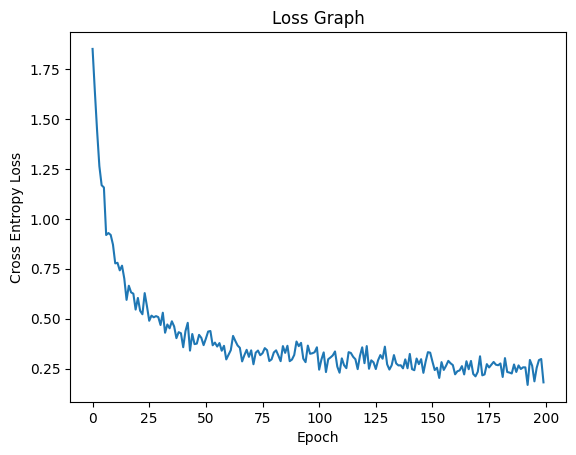

In [198]:
plt.plot(range(epochs),losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

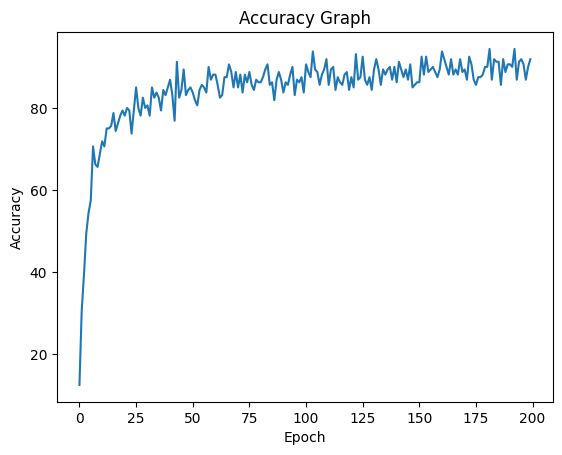

In [199]:
plt.plot(range(epochs),accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.show();

In [200]:
model.eval()

with torch.no_grad():
    y_val = model(cat_test,cont_test)
    print("Loss on test set:",criterion(y_val,y_test).item())
    print("Accuracy on test set:",round((torch.max(y_val,1)[1]==y_test).sum().item()/len(y_test) * 100,2))

Loss on test set: 0.17356741428375244
Accuracy on test set: 97.5


## Saving the model for inference purposes

In [201]:
torch.save(model,'drug_classifier.pt')

In [238]:
loaded_model = torch.load("drug_classifier.pt")
loaded_model

/tmp/ipykernel_36/2952343499.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("drug_classifier.pt")


ANN(
  (embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 2)
    (2): Embedding(2, 1)
  )
  (embeddings_dropout): Dropout(p=0.4, inplace=False)
  (cont_batch_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=150, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=200, out_features=5, bias=True)
  )
)

## Model Inference

In [232]:
def test_data(model):
    sex = input("What is your sex? (M/F)").upper()
    bp = input("How is your blood pressure? (LOW/NORMAL/HIGH)").upper()
    cholesterol = input("What is your cholesterol level? (HIGH/NORMAL)").upper()
    age = float(input("What is your age?"))
    na_to_k = float(input("What is the Sodium-to-Potassium ratio in your blood?"))
    
    sex_map = {'F': 0, 'M': 1}
    bp_map = {'HIGH': 0, 'LOW': 1, 'NORMAL': 2}
    cholesterol_map = {'HIGH': 0, 'NORMAL': 1}
    
    sex = sex_map[sex]
    bp = bp_map[bp]
    cholesterol = cholesterol_map[cholesterol]
    
    cats = torch.tensor([sex,bp,cholesterol],dtype=torch.int64).reshape(1,-1).cuda()
    conts = torch.tensor([age,na_to_k],dtype=torch.float).reshape(1,-1).cuda()
   
    model.eval()  
    
    with torch.no_grad():
        pred = model(cats,conts)
        
    print(f"The most accurate drug for you would be {encoded_labels[pred.argmax().item()]}.")

In [233]:
test_data(model)

What is your sex? (M/F) m
How is your blood pressure? (LOW/NORMAL/HIGH) normal
What is your cholesterol level? (HIGH/NORMAL) high
What is your age? 32
What is the Sodium-to-Potassium ratio in your blood? 4.6732


The most accurate drug for you would be drugX.


In [234]:
test_data(model)

What is your sex? (M/F) f
How is your blood pressure? (LOW/NORMAL/HIGH) high
What is your cholesterol level? (HIGH/NORMAL) high
What is your age? 41
What is the Sodium-to-Potassium ratio in your blood? 23.7812


The most accurate drug for you would be DrugY.


In [235]:
test_data(model)

What is your sex? (M/F) m
How is your blood pressure? (LOW/NORMAL/HIGH) low
What is your cholesterol level? (HIGH/NORMAL) normal
What is your age? 22
What is the Sodium-to-Potassium ratio in your blood? 13.9615


The most accurate drug for you would be drugX.


In [236]:
test_data(model)

What is your sex? (M/F) f
How is your blood pressure? (LOW/NORMAL/HIGH) low
What is your cholesterol level? (HIGH/NORMAL) high
What is your age? 25
What is the Sodium-to-Potassium ratio in your blood? 12.1097


The most accurate drug for you would be drugC.


In [237]:
test_data(model)

What is your sex? (M/F) m
How is your blood pressure? (LOW/NORMAL/HIGH) normal
What is your cholesterol level? (HIGH/NORMAL) normal
What is your age? 28
What is the Sodium-to-Potassium ratio in your blood? 16.7385


The most accurate drug for you would be DrugY.
